In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

# import os
# if os.name == 'posix' :
#     plt.rc('font', family='AppleGothic')
# else :
#     plt.rc('font', family='Malgun Gothic')
    
plt.rc('axes', unicode_minus=False)

plt.rcParams['font.family'] = 'NanumGothic' 
plt.rcParams['axes.unicode_minus'] = False
import koreanize_matplotlib

In [2]:
# !sudo apt update

In [3]:
# !sudo apt install fonts-nanum

## 투표수
- user question record 테이블에서 악성 유저라고 판단된 user id를 제외
    - timeline report 테이블에서 신고 기록이 있는 유저 id 모두 삭제
- 날짜별로 투표 생성된 수를 계산 (DAU / WAU와 비슷하게?)
    - 한 유저가 투표를 여러번 참여했더라도, 여러명의 유저에게 앱 사용을 유도하는 것
    - 그러므로, DAU라 하더라도 해당 유저의 당일 방문 여부를 잡는게 아니라, 당일 투표가 발생된 수를 지표로 하는 것이 어떠한가

### 데이터 불러오기

In [4]:
timeline_df = pd.read_parquet('./votes/accounts_timelinereport.parquet')
timeline_df.head()

,id,reason,created_at,reported_user_id,user_id,user_question_record_id
0,28,타인을 사칭함,2023-05-06 04:44:57,874587,885082,3920588
1,37,친구를 비하하거나 조롱하는 어투,2023-05-06 05:41:19,881048,881298,4018679
2,46,친구를 비하하거나 조롱하는 어투,2023-05-06 06:26:59,887882,881945,4120914
3,64,허위 사실 언급,2023-05-06 07:07:46,888610,893684,4143049
4,65,허위 사실 언급,2023-05-06 07:07:52,888610,893684,4143049


In [5]:
userquestion_df = pd.read_parquet('./votes/accounts_userquestionrecord.parquet')
userquestion_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
0,771777,C,2023-04-28 12:27:49,849469,252,849436,998458,0,N,2023-04-28 12:27:49,0,0
1,771800,C,2023-04-28 12:28:02,849446,244,849436,998459,0,N,2023-04-28 12:28:02,0,0
2,771812,C,2023-04-28 12:28:09,849454,183,849436,998460,1,N,2023-04-28 12:28:09,0,0
3,771828,C,2023-04-28 12:28:16,847375,101,849436,998461,0,N,2023-04-28 12:28:16,0,0
4,771851,C,2023-04-28 12:28:26,849477,209,849436,998462,1,N,2023-04-28 12:28:26,0,0


### 악성 유저 제외하기

In [6]:
# 신고당한 유저 id 리스트

print(f"신고당한 유저 수 : {timeline_df['reported_user_id'].nunique()}")
report_user_list = list(timeline_df['reported_user_id'].unique())
report_user_list

신고당한 유저 수 : 125


[874587,
 881048,
 887882,
 888610,
 884536,
 895726,
 876060,
 885328,
 884885,
 890492,
 887103,
 885473,
 939196,
 837235,
 870766,
 883543,
 880089,
 894246,
 885047,
 883505,
 877824,
 1003953,
 880230,
 917587,
 1084077,
 916471,
 885129,
 1115501,
 1068718,
 1142421,
 1138955,
 1143564,
 1130375,
 1150928,
 1144475,
 891201,
 962262,
 1156031,
 967873,
 1156093,
 1144389,
 1155224,
 1131675,
 1180713,
 1207119,
 1166883,
 1182739,
 1187305,
 1173995,
 1139317,
 1217590,
 1180707,
 1231232,
 1094588,
 1186756,
 1234199,
 1089675,
 1058015,
 1220102,
 1214735,
 1234413,
 1207784,
 866940,
 1140485,
 1127911,
 1237853,
 1186397,
 1250642,
 1185964,
 973584,
 1270621,
 1251559,
 1267449,
 1214817,
 1155289,
 1270083,
 1212252,
 1143862,
 1219972,
 1272969,
 1207467,
 1225963,
 1235698,
 1271892,
 1186295,
 1229462,
 1306868,
 1143329,
 1061811,
 1275061,
 1078669,
 1276950,
 1161757,
 1196718,
 1294069,
 1151668,
 1028093,
 1367093,
 1138757,
 1373786,
 956256,
 1372985,
 1138167,
 

### 날짜별 투표수 확인하기

- 23년 5~7월 데이터만 추리기

In [7]:
vote_df = userquestion_df[(userquestion_df['created_at'] >= '2023-05-01') & (userquestion_df['created_at'] < '2023-08-01')]
vote_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0


In [8]:
# 5~7월 제대로 들어갔는지 확인
vote_df['created_at'].describe()

count                          1181418
mean     2023-05-17 09:00:30.089484032
min                2023-05-01 03:37:42
25%      2023-05-10 14:45:38.249999872
50%         2023-05-16 01:46:47.500000
75%                2023-05-22 12:21:29
max                2023-07-31 23:43:10
Name: created_at, dtype: object

In [9]:
vote_df.shape

(1181418, 12)

- 악성 유저 제외하기

In [10]:
# 투표를 보낸 유저 중 신고 당했던 유저가 몇명이나 있는지 확인해보기
print(f"투표 기록 테이블에서 악성 유저로 예상되는 유저 수 : {vote_df[vote_df['user_id'].isin(report_user_list)]['user_id'].nunique()}")
print(f"악성 유저가 투표 보낸 수: {len(vote_df[vote_df['user_id'].isin(report_user_list)])}")

투표 기록 테이블에서 악성 유저로 예상되는 유저 수 : 112
악성 유저가 투표 보낸 수: 46329


In [11]:
# 악성 유저 제외한 테이블 만들기
votecnt_df = vote_df[~vote_df['user_id'].isin(report_user_list)]
votecnt_df.shape

(1135089, 12)

In [12]:
# 이 중에서 status가 B로 차단인 데이터는 삭제하기
votecnt_df['status'].value_counts()

status
C    1077836
I      56690
B        563
Name: count, dtype: int64

In [13]:
votecnt_df = votecnt_df[~(votecnt_df['status'] == 'B')]
votecnt_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0


- 날짜별 날짜별 투표한 유저 수 구하기

In [14]:
# 일별 데이터를 확인하기 위해서 연-월-일 컬럼 생성하기
votecnt_df['year_month_day'] = votecnt_df['created_at'].dt.strftime('%Y-%m-%d')
votecnt_df.head()

,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,year_month_day
30798,1481996,C,2023-05-01 03:37:42,855817,202,857913,1821408,0,N,2023-05-01 03:37:42,0,0,2023-05-01
30799,1482200,C,2023-05-01 03:38:24,855549,116,856430,1861799,0,N,2023-05-01 03:38:24,0,0,2023-05-01
30800,1482273,C,2023-05-01 03:38:38,855509,199,856430,1861800,0,N,2023-05-01 03:38:38,0,0,2023-05-01
30801,1482321,C,2023-05-01 03:38:48,855509,238,856430,1861801,0,N,2023-05-01 03:38:48,0,0,2023-05-01
30802,1482347,C,2023-05-01 03:38:53,860439,190,856430,1861802,0,N,2023-05-01 03:38:53,0,0,2023-05-01


In [15]:
# 날짜별 투표한 유저 수 구하기
daily_votecnt_df = votecnt_df.groupby(['year_month_day'])['user_id'].nunique().reset_index(name='voteduser_cnt')
daily_votecnt_df.head()

,year_month_day,voteduser_cnt
0,2023-05-01,324
1,2023-05-02,411
2,2023-05-03,752
3,2023-05-04,814
4,2023-05-05,1232


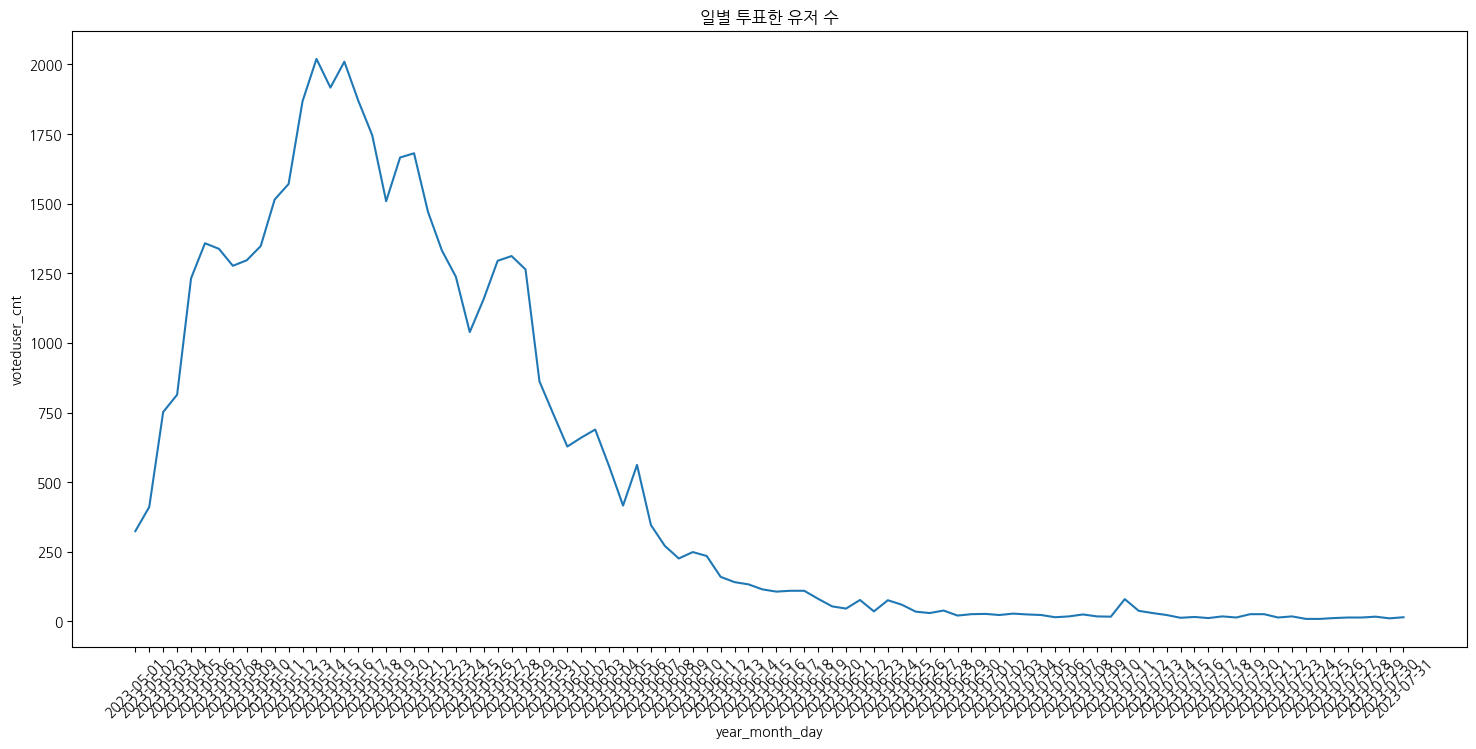

In [16]:
# 시각화
plt.figure(figsize=(18,8))
sns.lineplot(data=daily_votecnt_df, x='year_month_day', y='voteduser_cnt')
plt.title('일별 투표한 유저 수')
plt.xticks(rotation=45)
plt.show()

- 악성 유저 (신고된 유저)의 일별 투표 수는 어떨까?

In [17]:
# 악성 유저 테이블 만들기
votecnt_report_df = vote_df[vote_df['user_id'].isin(report_user_list)]

# 일별 데이터를 확인하기 위해서 연-월-일 컬럼 생성하기
votecnt_report_df['year_month_day'] = votecnt_report_df['created_at'].dt.strftime('%Y-%m-%d')
votecnt_report_df.head()

/tmp/ipykernel_449347/473960116.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  votecnt_report_df['year_month_day'] = votecnt_report_df['created_at'].dt.strftime('%Y-%m-%d')


,id,status,created_at,chosen_user_id,question_id,user_id,question_piece_id,has_read,answer_status,answer_updated_at,report_count,opened_times,year_month_day
55393,2351720,C,2023-05-02 22:22:58,865697,120,840685,3046553,1,N,2023-05-02 22:22:58,0,0,2023-05-02
55427,2352538,C,2023-05-02 22:24:50,867872,469,840685,3046555,0,N,2023-05-02 22:24:50,0,0,2023-05-02
55437,2352799,C,2023-05-02 22:25:26,867872,471,840685,3046556,0,N,2023-05-02 22:25:26,0,0,2023-05-02
55456,2353170,C,2023-05-02 22:26:17,840293,402,840685,3046557,0,N,2023-05-02 22:26:17,0,0,2023-05-02
56287,2379271,C,2023-05-02 23:16:31,862581,231,840685,3049448,1,N,2023-05-02 23:16:31,0,0,2023-05-02


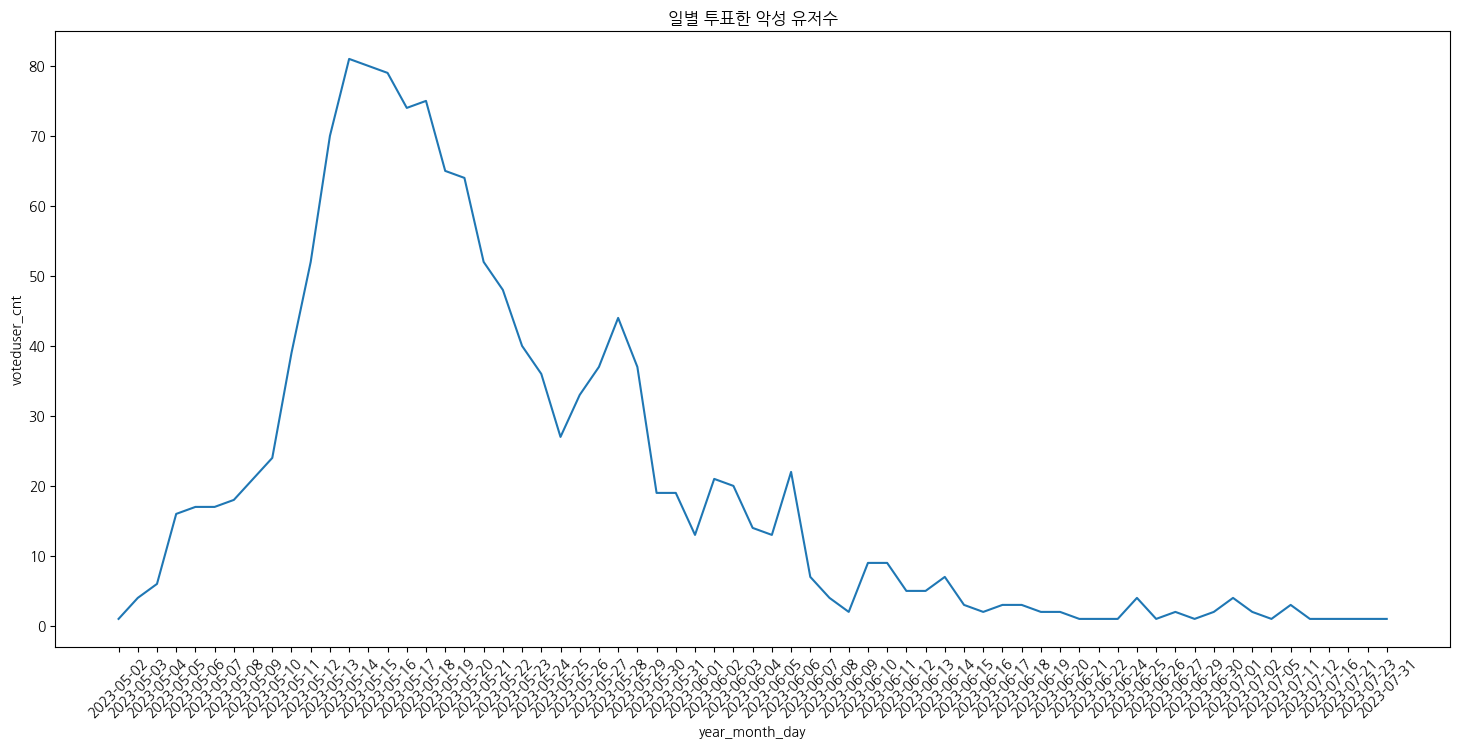

In [18]:
# 날짜별 투표한 악성 유저 수 
daily_votecnt_report_df = votecnt_report_df.groupby(['year_month_day'])['user_id'].nunique().reset_index(name='voteduser_cnt')

# 시각화
plt.figure(figsize=(18,8))
sns.lineplot(data=daily_votecnt_report_df, x='year_month_day', y='voteduser_cnt')
plt.title('일별 투표한 악성 유저수')
plt.xticks(rotation=45)
plt.show()

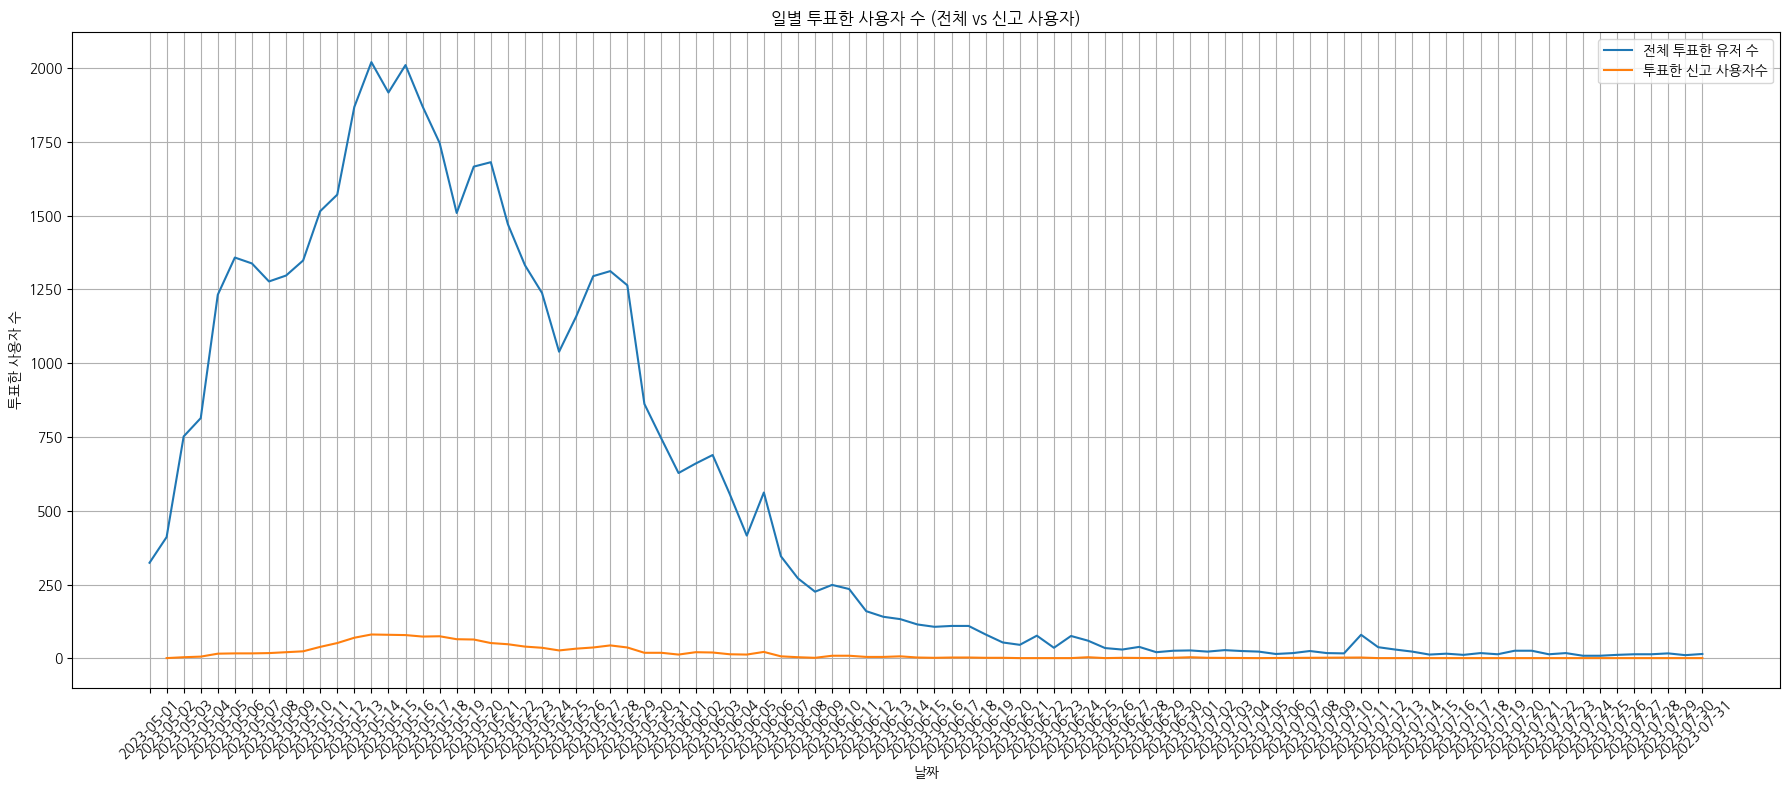

In [19]:
# 두 그래프 합쳐서 보기

plt.figure(figsize=(18,8))

# 전체 투표수
sns.lineplot(data=daily_votecnt_df, x='year_month_day', y='voteduser_cnt', label='전체 투표한 유저 수')

# 신고된 사용자 투표수
sns.lineplot(data=daily_votecnt_report_df, x='year_month_day', y='voteduser_cnt', label='투표한 신고 사용자수')

# 기타 설정
plt.title('일별 투표한 사용자 수 (전체 vs 신고 사용자)')
plt.xlabel('날짜')
plt.ylabel('투표한 사용자 수')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_449347/2540052432.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


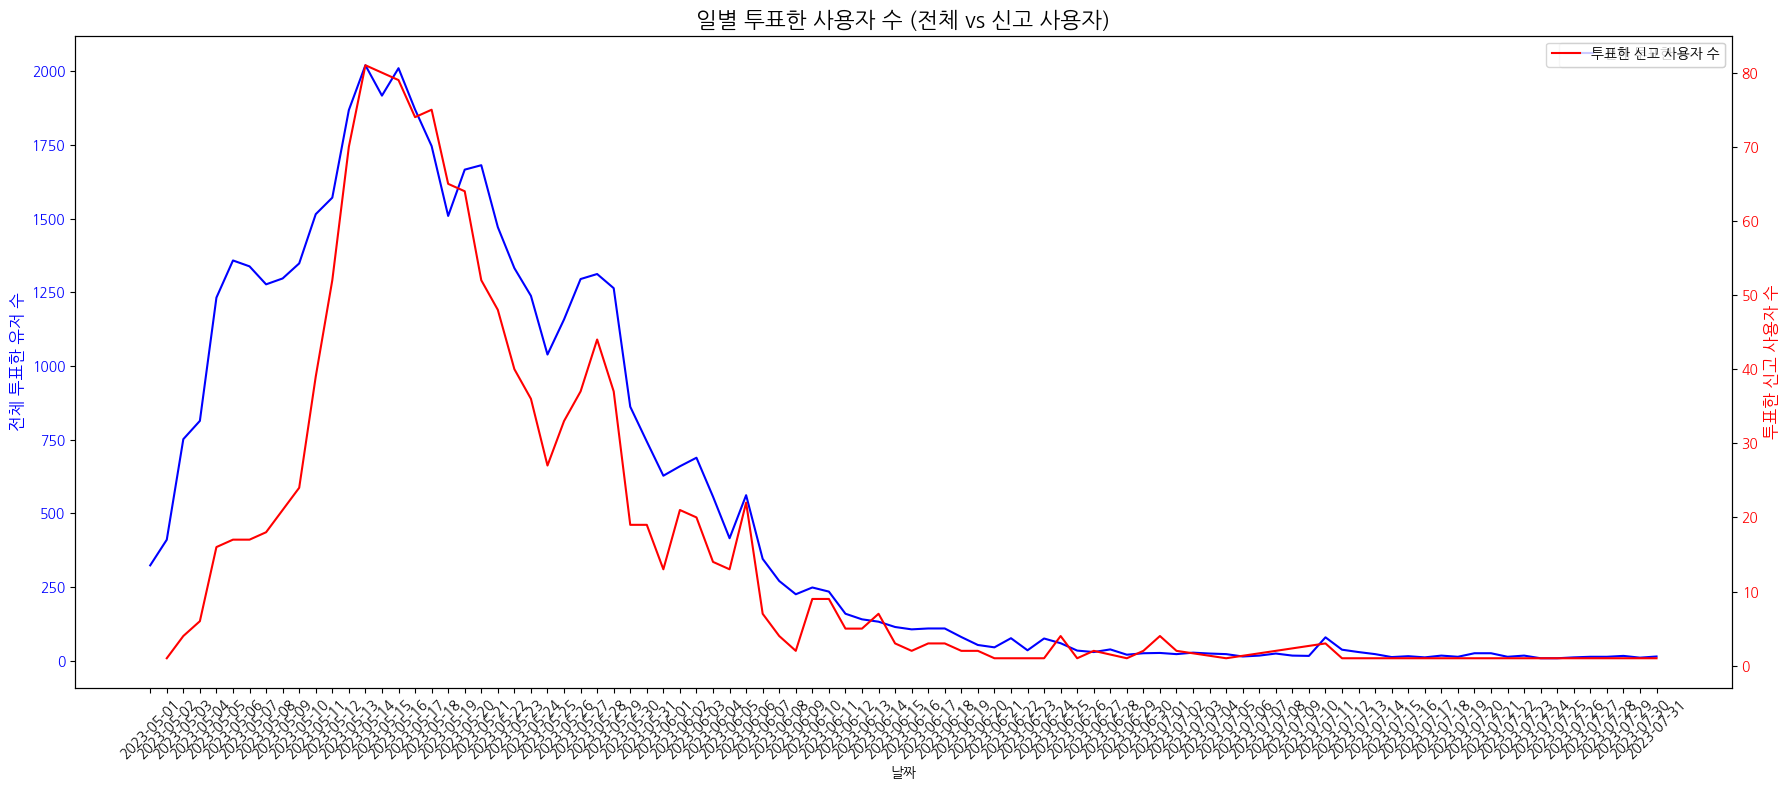

In [20]:
# 두 그래프의 투표수 범위를 다르게 봐보기

fig, ax1 = plt.subplots(figsize=(18,8))

# 첫 번째 y축 - 전체 투표수
sns.lineplot(
    data=daily_votecnt_df, x='year_month_day', y='voteduser_cnt',
    ax=ax1, label='전체 투표한 유저 수', color='blue'
)
ax1.set_ylabel('전체 투표한 유저 수', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 두 번째 y축 - 신고된 사용자 투표수
ax2 = ax1.twinx()  # 이중 y축 생성
sns.lineplot(
    data=daily_votecnt_report_df, x='year_month_day', y='voteduser_cnt',
    ax=ax2, label='투표한 신고 사용자 수', color='red'
)
ax2.set_ylabel('투표한 신고 사용자 수', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# x축 및 기타 설정
ax1.set_title('일별 투표한 사용자 수 (전체 vs 신고 사용자)', fontsize=16)
ax1.set_xlabel('날짜')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

- 신고된 사용자의 투표수가 지나치게 치솟는 순간을 기점으로 서비스 쇠퇴기 시작됨?

## 투표율
- hackle 데이터에서 당일 유입 사용자 중 투표에 참여한 사용자 비율

### 데이터 불러오기

## 질문 참여

### 데이터 불러오기

In [21]:
questionset_df = pd.read_parquet('./votes/polls_questionset.parquet')
questionset_df.head()

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477


## Vote 테이블에서 투표율 구하기
- 투표한 사람 수 / 전체 가입자 수 
    - 전체 가입자 수 : 가입자 수 - 탈퇴 회원 수
    - 현재 데이터에서 가입 날짜를 알 수 있는 가장 빠른 일자는 2023-03-29. 이 날을 앱 런친일이라고 가정하고 데이터 살펴보기

### 데이터 불러오기

#### User
- 유저 테이블
- block_user_id_list : 차단한 유저 id
- hide_user_id_list : 숨김처리한 유저 id
- pending_chat : 안읽은 채팅 수
- pending_votes : 확인 안한 투표 수 
- ban status (차탄 혹은 탈퇴한 유저인지 타입)
    - N : (Normal) 일반 유저, 정상적으로 활동 중인 사용자
    - W : (Withdrawn) 탈퇴한 유저
    - NB : (Normal Banned) 계정 정지된 일반 유저
    - RB : (Restricted Banned) 제한적으로 정지된 유저 (예: 특정 기능 제한)

In [22]:
user_df = pd.read_parquet('./votes/accounts_user.parquet')
user_df.head()

,id,is_superuser,is_staff,gender,point,friend_id_list,is_push_on,created_at,block_user_id_list,hide_user_id_list,ban_status,report_count,alarm_count,pending_chat,pending_votes,group_id
0,831956,1,1,None,600,"[1292473, 913158, 1488461, 1064695, 1043565, 1...",0,2023-03-29 03:44:14.047130,[],[],N,0,0,0,0,NaN
1,831962,0,0,F,2248,"[833025, 832642, 982531, 879496, 838541, 83752...",1,2023-03-29 05:18:56.162368,[],[],N,253,40878,5499,110,12.0
2,832151,0,0,M,1519,"[838785, 982531, 882567, 879496, 838541, 83649...",0,2023-03-29 12:56:34.989468,[],[],N,0,37,0,47,1.0
3,832340,0,0,F,57,"[841345, 982531, 838785, 963714, 882567, 83252...",1,2023-03-29 12:56:35.020790,[],[],N,0,19,0,21,1.0
4,832520,0,0,M,1039,"[874050, 849763, 874212, 844297, 838541, 84004...",0,2023-03-29 12:56:35.049311,[],[],N,0,29,0,15,12.0


In [23]:
# 탈퇴 회원 기록 테이블
userwithdraw_df = pd.read_parquet('./votes/accounts_userwithdraw.parquet')
userwithdraw_df.head()

,id,reason,created_at
0,42,재밌는 질문이 없어서,2023-03-29 13:22:12
1,43,함께 할 친구가 없어서,2023-03-29 13:24:59
2,44,함께 할 친구가 없어서,2023-03-29 13:53:32
3,45,함께 할 친구가 없어서,2023-03-29 13:54:03
4,46,재밌는 질문이 없어서,2023-03-30 00:31:19


- 일별 누적 회원 구하기

In [24]:
# 일별 가입 회원 수 구하기
user__df = user_df.copy()
# 23년 7월 31일까지의 데이터만 사용
user__df = user__df[user__df['created_at'] < '2023-08-01']
# 년-월-일 컬럼 만들기
user__df['year_month_day'] = user__df['created_at'].dt.strftime('%Y-%m-%d')
# 일별로 유저id의 유니크값 수 구하기
daily_join_user_df = user__df.groupby(['year_month_day'])['id'].nunique().reset_index(name='daily_join')
daily_join_user_df.head()

,year_month_day,daily_join
0,2023-03-29,11
1,2023-03-31,22
2,2023-04-01,16
3,2023-04-02,1
4,2023-04-03,5


In [25]:
# 일별 탈퇴 회원 
userwithdraw__df = userwithdraw_df.copy()
# 23년 7월 31일까지의 데이터만 사용
userwithdraw__df = userwithdraw__df[userwithdraw__df['created_at'] < '2023-08-01']
# 년-월-일 컬럼 만들기
userwithdraw__df['year_month_day'] = userwithdraw__df['created_at'].dt.strftime('%Y-%m-%d')
# 일별로 탈퇴 회원 수 구하기
daily_withdraw_user_df = userwithdraw__df.groupby(['year_month_day']).size().reset_index(name='daily_withdraw')
daily_withdraw_user_df.head()

,year_month_day,daily_withdraw
0,2023-03-29,4
1,2023-03-30,3
2,2023-03-31,10
3,2023-04-01,9
4,2023-04-02,4


In [26]:
# 일별 가입자 수 데이터랑 탈퇴 수 데이터 합치기
total_user_df = pd.merge(daily_join_user_df, daily_withdraw_user_df, on='year_month_day', how='outer')
total_user_df.head()

,year_month_day,daily_join,daily_withdraw
0,2023-03-29,11.0,4.0
1,2023-03-31,22.0,10.0
2,2023-04-01,16.0,9.0
3,2023-04-02,1.0,4.0
4,2023-04-03,5.0,3.0


In [27]:
# 결측치 확인
total_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year_month_day  125 non-null    object 
 1   daily_join      124 non-null    float64
 2   daily_withdraw  119 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [28]:
# 결축치는 0으로 채워주기
total_user_df = total_user_df.fillna(0)
total_user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year_month_day  125 non-null    object 
 1   daily_join      125 non-null    float64
 2   daily_withdraw  125 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [29]:
# 일별 순수 가입 유저 확인 (가입 유저 - 탈퇴 유저)
total_user_df['remain_user'] = total_user_df['daily_join'] - total_user_df['daily_withdraw']
total_user_df.head()

,year_month_day,daily_join,daily_withdraw,remain_user
0,2023-03-29,11.0,4.0,7.0
1,2023-03-31,22.0,10.0,12.0
2,2023-04-01,16.0,9.0,7.0
3,2023-04-02,1.0,4.0,-3.0
4,2023-04-03,5.0,3.0,2.0


In [30]:
# 누적 유저 수 구하기
total_user_df['total_user'] = total_user_df['remain_user'].cumsum()
total_user_df.head()

,year_month_day,daily_join,daily_withdraw,remain_user,total_user
0,2023-03-29,11.0,4.0,7.0,7.0
1,2023-03-31,22.0,10.0,12.0,19.0
2,2023-04-01,16.0,9.0,7.0,26.0
3,2023-04-02,1.0,4.0,-3.0,23.0
4,2023-04-03,5.0,3.0,2.0,25.0


In [31]:
# 현재 우리 팀에서 필요한 5~7월 데이터만 남기기
total_user_df = total_user_df[(total_user_df['year_month_day'] >= '2023-05-01') & (total_user_df['year_month_day'] < '2023-08-01')]
total_user_df.head()

,year_month_day,daily_join,daily_withdraw,remain_user,total_user
32,2023-05-01,4640.0,472.0,4168.0,20850.0
33,2023-05-02,4071.0,468.0,3603.0,24453.0
34,2023-05-03,4231.0,429.0,3802.0,28255.0
35,2023-05-04,3473.0,403.0,3070.0,31325.0
36,2023-05-05,6334.0,719.0,5615.0,36940.0


- 앞서 구한, 일자별 투표한 유저수 데이터와 합쳐서 투표율 구하기

In [32]:
total_vote_user_df = pd.merge(total_user_df, daily_votecnt_df, on='year_month_day', how='outer')
total_vote_user_df.head()

,year_month_day,daily_join,daily_withdraw,remain_user,total_user,voteduser_cnt
0,2023-05-01,4640.0,472.0,4168.0,20850.0,324
1,2023-05-02,4071.0,468.0,3603.0,24453.0,411
2,2023-05-03,4231.0,429.0,3802.0,28255.0,752
3,2023-05-04,3473.0,403.0,3070.0,31325.0,814
4,2023-05-05,6334.0,719.0,5615.0,36940.0,1232


In [33]:
# 투표율 컬럼 생성
total_vote_user_df['vote_rate'] = total_vote_user_df['voteduser_cnt'] / total_vote_user_df['total_user']
total_vote_user_df.head()

,year_month_day,daily_join,daily_withdraw,remain_user,total_user,voteduser_cnt,vote_rate
0,2023-05-01,4640.0,472.0,4168.0,20850.0,324,0.015540
1,2023-05-02,4071.0,468.0,3603.0,24453.0,411,0.016808
2,2023-05-03,4231.0,429.0,3802.0,28255.0,752,0.026615
3,2023-05-04,3473.0,403.0,3070.0,31325.0,814,0.025986
4,2023-05-05,6334.0,719.0,5615.0,36940.0,1232,0.033351


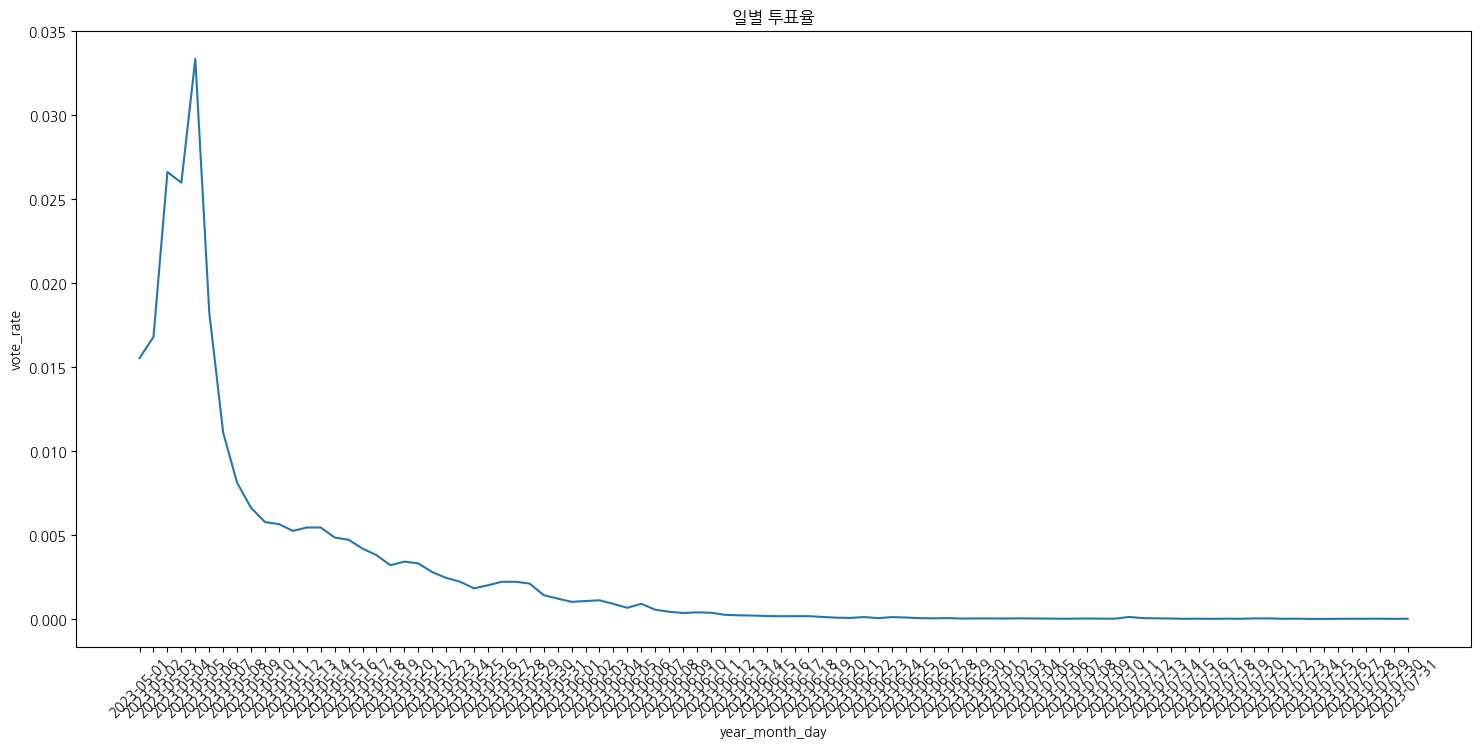

In [34]:
# 시각화
plt.figure(figsize=(18,8))
sns.lineplot(data=total_vote_user_df, x='year_month_day', y='vote_rate')
plt.title('일별 투표율')
plt.xticks(rotation=45)
plt.show()

- 투표율과 투표수 비교해보기

/tmp/ipykernel_449347/2872318453.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


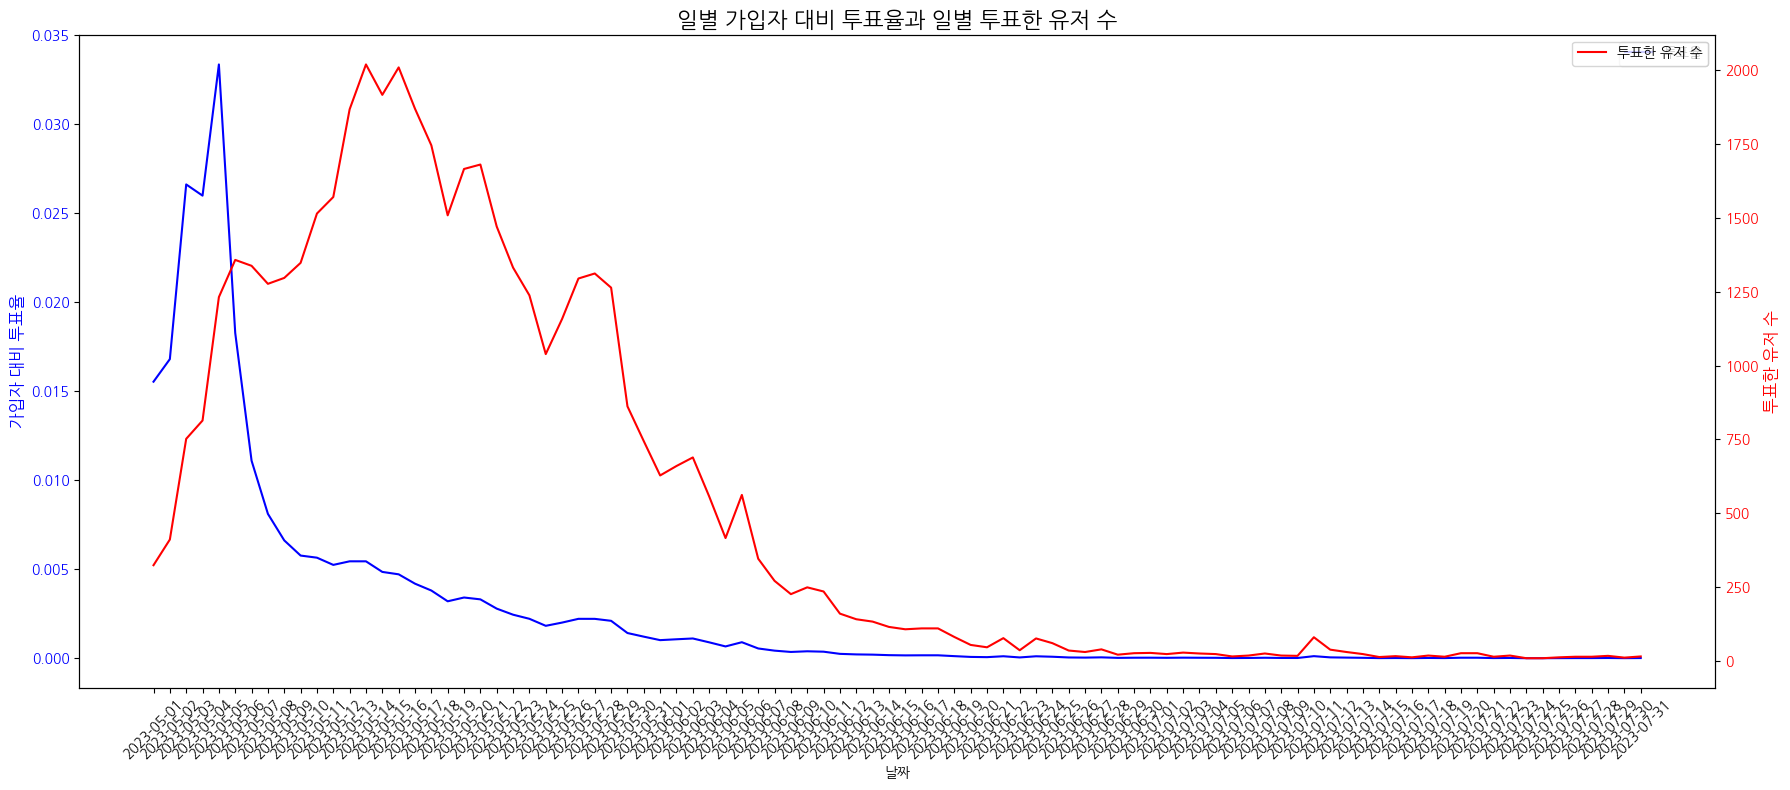

In [35]:
# 두 그래프의 투표수 범위를 다르게 봐보기

fig, ax1 = plt.subplots(figsize=(18,8))

# 첫 번째 y축 - 투표율
sns.lineplot(
    data=total_vote_user_df, x='year_month_day', y='vote_rate',
    ax=ax1, label='투표율', color='blue'
)
ax1.set_ylabel('가입자 대비 투표율', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 두 번째 y축 - 투표수
ax2 = ax1.twinx()  # 이중 y축 생성
sns.lineplot(
    data=daily_votecnt_df, x='year_month_day', y='voteduser_cnt',
    ax=ax2, label='투표한 유저 수', color='red'
)
ax2.set_ylabel('투표한 유저 수', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# x축 및 기타 설정
ax1.set_title('일별 가입자 대비 투표율과 일별 투표한 유저 수', fontsize=16)
ax1.set_xlabel('날짜')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

- 번외. 가입 수 와 탈퇴 수 그래프로 비교해보기

In [40]:
daily_join_user_df['cumsum'] = daily_join_user_df['daily_join'].cumsum()
daily_join_user_df.head()

,year_month_day,daily_join,cumsum
0,2023-03-29,11,11
1,2023-03-31,22,33
2,2023-04-01,16,49
3,2023-04-02,1,50
4,2023-04-03,5,55


In [39]:
daily_withdraw_user_df['cumsum'] = daily_withdraw_user_df['daily_withdraw'].cumsum()
daily_withdraw_user_df.head()

,year_month_day,daily_withdraw,cumsum
0,2023-03-29,4,4
1,2023-03-30,3,7
2,2023-03-31,10,17
3,2023-04-01,9,26
4,2023-04-02,4,30


/tmp/ipykernel_449347/4176181148.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


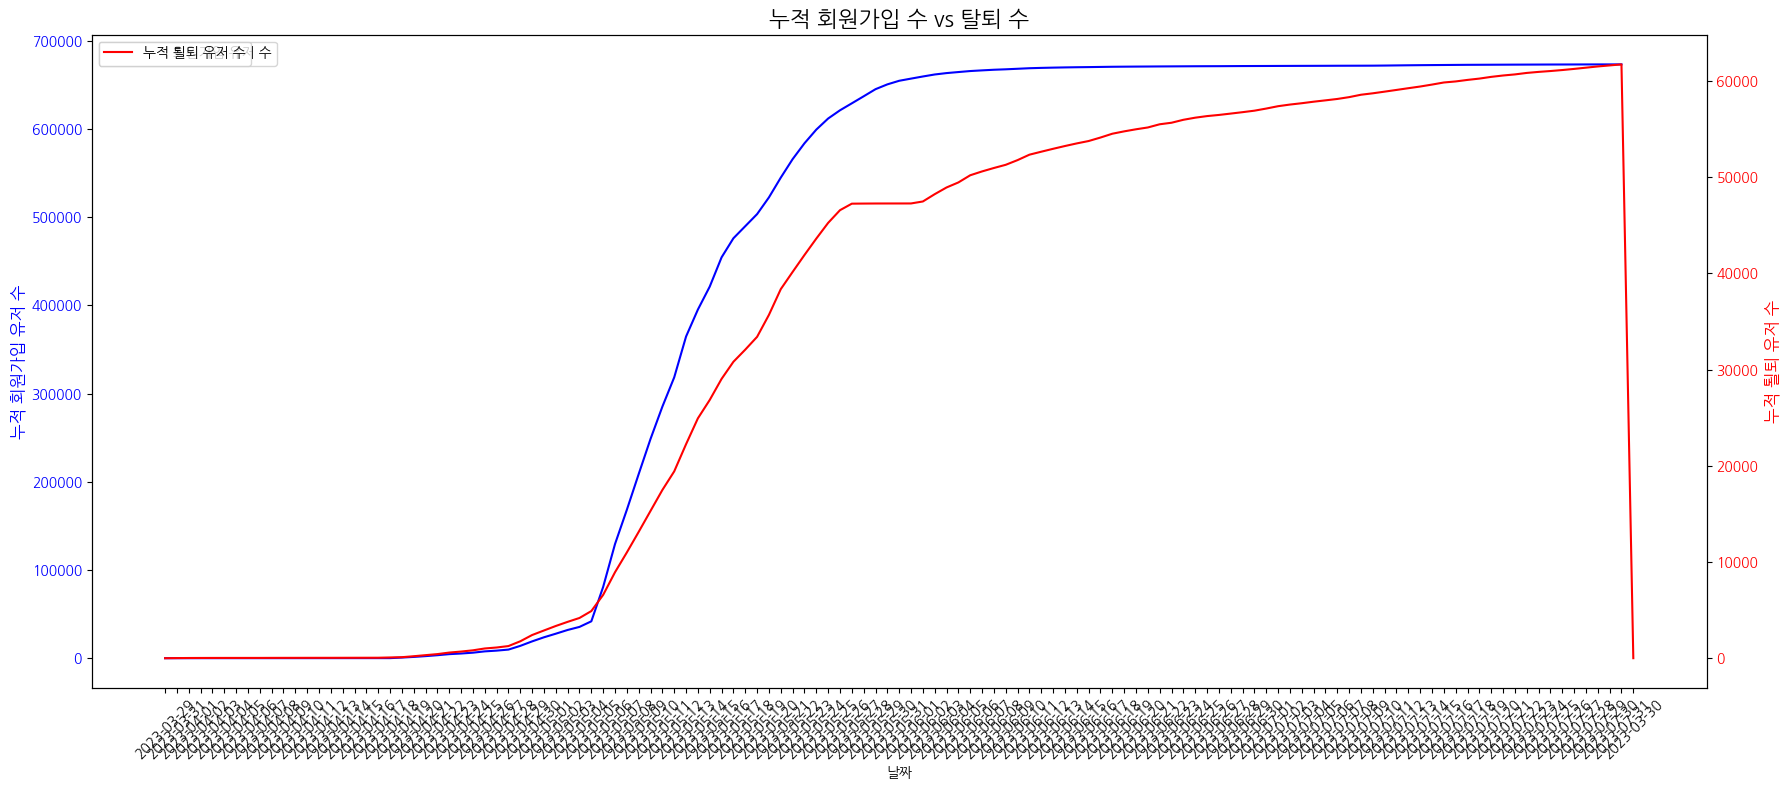

In [ ]:
# 시각화

fig, ax1 = plt.subplots(figsize=(18,8))

# 첫 번째 y축 - 누적 회원가입 유저 수
sns.lineplot(
    data=daily_join_user_df, x='year_month_day', y='cumsum',
    ax=ax1, label='누적 회원가입 유저 수', color='blue'
)
ax1.set_ylabel('누적 회원가입 유저 수', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 두 번째 y축 - 누적 퇼퇴 유저 수
ax2 = ax1.twinx()  # 이중 y축 생성
sns.lineplot(
    data=daily_withdraw_user_df, x='year_month_day', y='cumsum',
    ax=ax2, label='누적 퇼퇴 유저 수', color='red'
)
ax2.set_ylabel('누적 퇼퇴 유저 수', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# x축 및 기타 설정
ax1.set_title('누적 회원가입 수 vs 탈퇴 수', fontsize=16)
ax1.set_xlabel('날짜')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_449347/1251246239.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


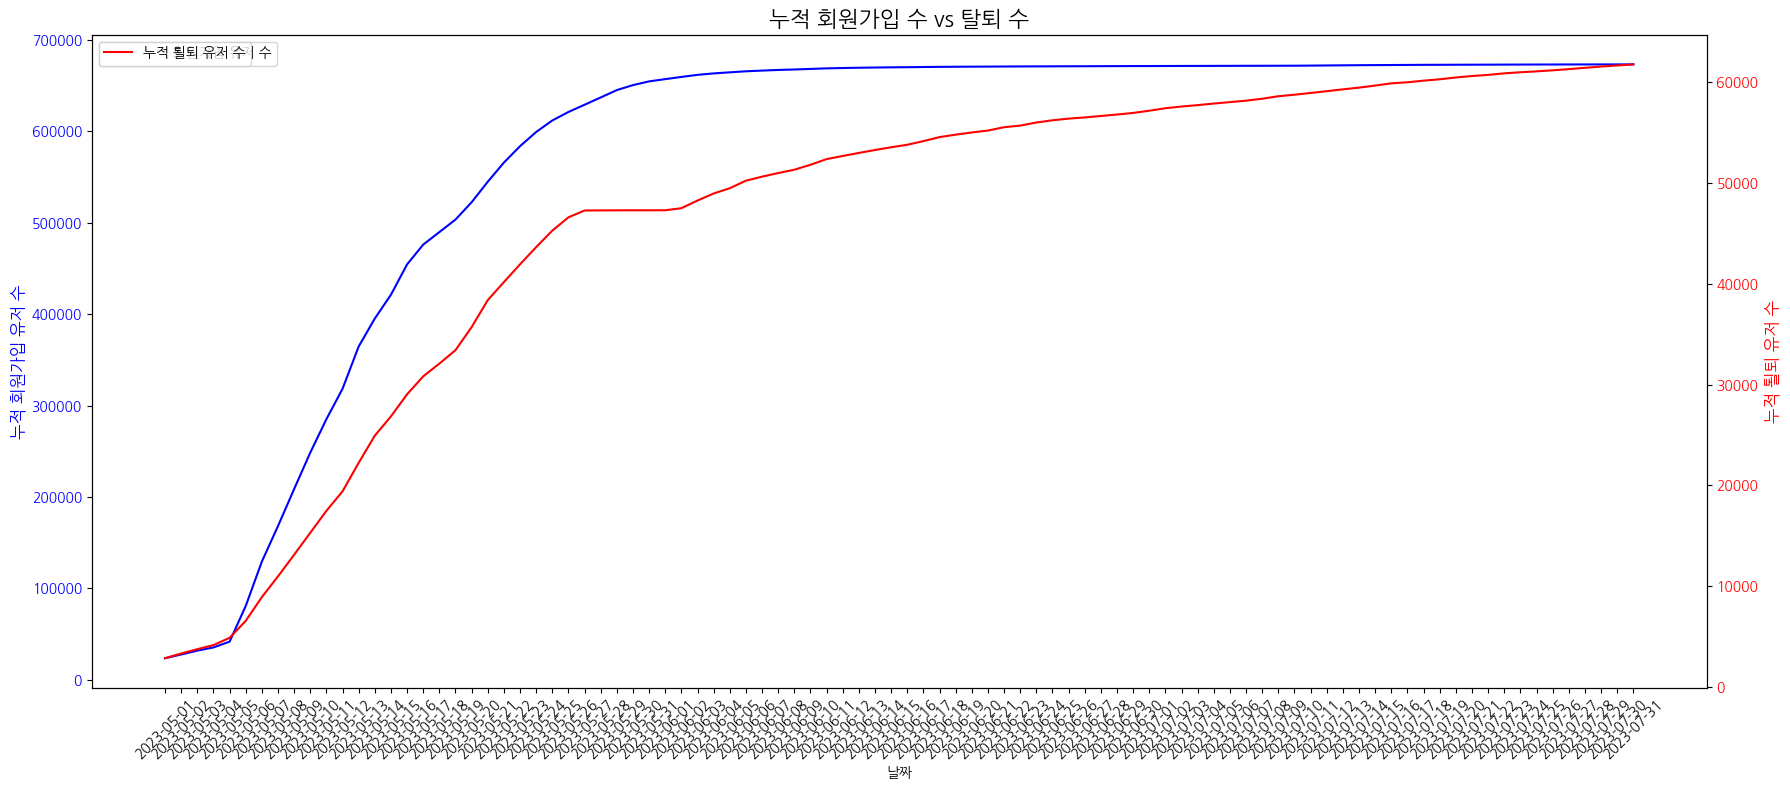

In [42]:
# 5월부터 7월까지 봐보기

daily_join_user_567_df = daily_join_user_df[(daily_join_user_df['year_month_day'] >= '2023-05-01') & ((daily_join_user_df['year_month_day'] < '2023-08-01'))]
daily_withdraw_user_567_df = daily_withdraw_user_df[(daily_withdraw_user_df['year_month_day'] >= '2023-05-01') & ((daily_withdraw_user_df['year_month_day'] < '2023-08-01'))]

fig, ax1 = plt.subplots(figsize=(18,8))

# 첫 번째 y축 - 누적 회원가입 유저 수
sns.lineplot(
    data=daily_join_user_567_df, x='year_month_day', y='cumsum',
    ax=ax1, label='누적 회원가입 유저 수', color='blue'
)
ax1.set_ylabel('누적 회원가입 유저 수', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 두 번째 y축 - 누적 퇼퇴 유저 수
ax2 = ax1.twinx()  # 이중 y축 생성
sns.lineplot(
    data=daily_withdraw_user_567_df, x='year_month_day', y='cumsum',
    ax=ax2, label='누적 퇼퇴 유저 수', color='red'
)
ax2.set_ylabel('누적 퇼퇴 유저 수', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# x축 및 기타 설정
ax1.set_title('누적 회원가입 수 vs 탈퇴 수', fontsize=16)
ax1.set_xlabel('날짜')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()